In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column



# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
# Start Date and End Date
start_date = session.query(Measurement.date).order_by(Measurement.date).first()
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"Start date : {start_date[0]}")
print(f"End date   : {end_date[0]}")


Start date : 2010-01-01
End date   : 2017-08-23


In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date = dt.datetime.strptime(end_date[0], "%Y-%m-%d")
one_year_ago = dt.date(last_date.year - 1, last_date.month, last_date.day)
print(f"The date of one year ago from the last data point in the database:", one_year_ago)

The date of one year ago from the last data point in the database: 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
one_year_precipitation = session.query(Measurement.date, Measurement.prcp).\
                                       filter(Measurement.date >= one_year_ago).all()


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_precipitation_df = pd.DataFrame(one_year_precipitation, columns = ["Date", "Precipitation"])
one_year_precipitation_df = one_year_precipitation_df.set_index("Date")


In [15]:
# Sort the dataframe by date
sorted_df = one_year_precipitation_df.sort_values("Date", ascending = True)
sorted_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


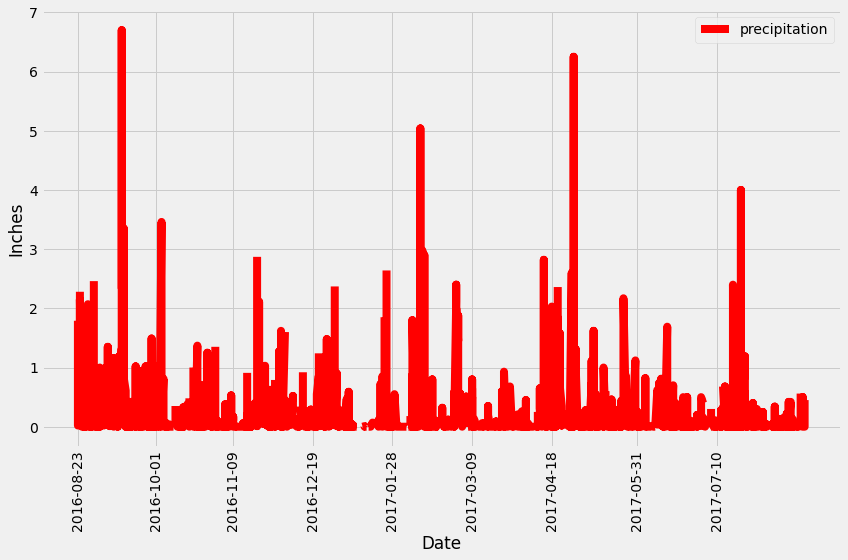

In [16]:

# Use Pandas Plotting with Matplotlib to plot the data
xloc = ["2016-08-23", "2016-10-01", "2016-11-09", "2016-12-19", "2017-01-28", "2017-03-09", "2017-04-18", "2017-05-31", "2017-07-10"] 

# Plot using pyplot
plt.figure(figsize = (12, 8))
plt.plot(sorted_df.index, sorted_df["Precipitation"], color = "red", linewidth = 8)
plt.xticks(xloc, rotation = 90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["precipitation"])
plt.tight_layout()
plt.savefig("images/precipitation.PNG")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data

sorted_df.describe().round(2)

,Precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count() 
print(f'There are {station_count} stations available in this dateset.')

There are 9 stations available in this dateset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_number = 'USC00519281'
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == station_number).all()

[(54.0, 85.0, 71.66378066378067)]

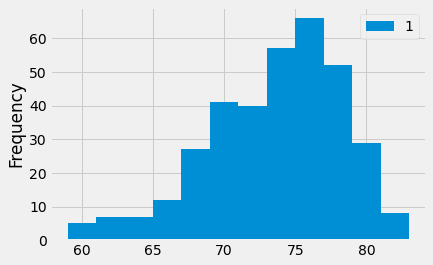

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_highest_obs = station_activity[0][0]

results = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-24").\
                        filter(Measurement.date <= "2017-08-23").\
                        filter(Measurement.station == station_highest_obs).all()

# convert to dataframe
results_df = pd.DataFrame(results)

# historgram 
results_df.plot.hist(bins=12)
plt.savefig("images/stations_histogram.PNG")

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))
tmin, tavg, tmax = calc_temps('2011-02-28', '2011-03-05')[0]

[(61.0, 69.75510204081633, 75.0)]


<ipython-input-24-8844e3ca37f5>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


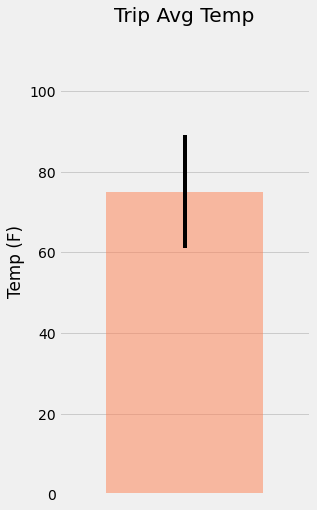

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
yerr = tmax-tmin
ax.bar(1, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.3, .3)
plt.savefig("images/Trip_Average_Temp.PNG")
fig.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station,  Station.name, Station.latitude, Station.longitude, Station.elevation).\
   filter(Station.station == Measurement.station).\
       filter(Measurement.date >= '2011-02-28').filter(Measurement.date <= '2011-03-05').\
           group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()


[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = dt.date(2017, 3, 1)
end_date = dt.date(2017, 3, 10)

# Use the start and end date to create a range of dates
date_list = pd.date_range(start_date, end_date).tolist()

# Strip off the year and save a list of %m-%d strings
date_str_list = [date_list[i].strftime("%m-%d") for i in range(len(date_list))]

# Loop through the list of %m-%d strings and calculate the normals for each date
for i in range(len(date_str_list)):
    daily_normal = list(np.ravel(daily_normals(date_str_list[i])))
    normals.append(daily_normal)
normals

[[64.0, 70.0327868852459, 76.0],
 [61.0, 70.36666666666666, 78.0],
 [60.0, 70.06896551724138, 78.0],
 [57.0, 69.27272727272727, 77.0],
 [60.0, 67.89090909090909, 76.0],
 [60.0, 69.20338983050847, 76.0],
 [60.0, 69.17241379310344, 78.0],
 [59.0, 68.72413793103448, 78.0],
 [57.0, 68.56140350877193, 75.0],
 [57.0, 69.12280701754386, 75.0]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])
normals_df["date"] = date_list
normals_df.set_index("date", inplace = True)
normals_df

,tmin,tavg,tmax
date,,,
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0
2017-03-06,60.0,69.203390,76.0
2017-03-07,60.0,69.172414,78.0
2017-03-08,59.0,68.724138,78.0
2017-03-09,57.0,68.561404,75.0


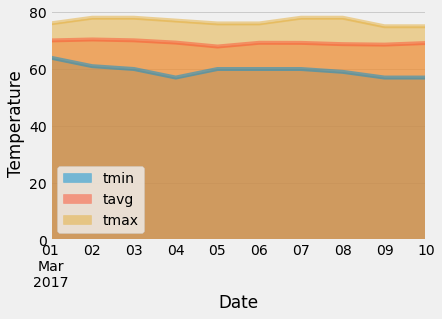

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked = False)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.savefig("images/Trip_Daily_Temp.PNG")
plt.show()